In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import RandomOverSampler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
sc = StandardScaler()

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


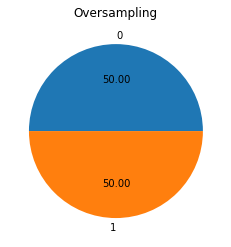

In [4]:
df['ever_married'].replace('Yes',1,inplace=True)
df['ever_married'].replace('No',0,inplace=True)
df['bmi'].fillna(df['bmi'].median(),inplace=True)
df['work_type'].replace(to_replace=['Private','Self-employed','Govt_job','children','Never_worked','Other'],value=[1,2,3,4,5,6],inplace=True)
df['smoking_status'].replace(to_replace=['formerly smoked', 'never smoked', 'smokes', 'Unknown'],value=[1,2,3,0],inplace=True)
df['Residence_type'].replace(to_replace=['Rural','Urban'],value=[0,1],inplace=True)
df['gender'].replace(to_replace=['Male','Female','Other'],value=[1,0,2],inplace=True)
x = df.iloc[:,1:11].values
y = df.iloc[:,11].values
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=101)
ros = RandomOverSampler(sampling_strategy="not majority")
X_res,y_res = ros.fit_resample(x,y) #for plotting the pie chart
X_res_train, y_res_train = ros.fit_resample(X_train,y_train)
X_res_test, y_res_test = ros.fit_resample(X_test,y_test)
unique_elements, counts_elements = np.unique(y_res, return_counts=True)
fig,ax = plt.subplots()
ax.pie(counts_elements,labels=unique_elements,autopct="%.2f")
ax.set_facecolor("white")
plt.title("Oversampling")
X_train = sc.fit_transform(X_res_train)
X_test = sc.transform(X_res_test)

In [5]:
X_train = np.array(X_res_train)
y_train = np.array(y_res_train)
y_test = np.array(y_res_test)
X_test = np.array(X_res_test)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256,input_shape=(X_train.shape[1],),activation="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(loss="binary_crossentropy",optimizer = 'Adam',metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)
r = model.fit(X_train,y_train,callbacks=[es],epochs=35,batch_size=10,shuffle=True,validation_data=(X_test,y_test))

Epoch 1/35
683/683 [==============================] - 6s 6ms/step - loss: 0.6376 - accuracy: 0.6748 - val_loss: 0.5322 - val_accuracy: 0.7351
Epoch 2/35
683/683 [==============================] - 4s 6ms/step - loss: 0.5575 - accuracy: 0.7321 - val_loss: 0.5186 - val_accuracy: 0.7407
Epoch 3/35
683/683 [==============================] - 4s 6ms/step - loss: 0.5351 - accuracy: 0.7422 - val_loss: 0.5271 - val_accuracy: 0.7503
Epoch 4/35
683/683 [==============================] - 4s 5ms/step - loss: 0.5181 - accuracy: 0.7479 - val_loss: 0.5155 - val_accuracy: 0.7324
Epoch 5/35
683/683 [==============================] - 4s 5ms/step - loss: 0.5080 - accuracy: 0.7549 - val_loss: 0.5460 - val_accuracy: 0.7106
Epoch 6/35
683/683 [==============================] - 4s 6ms/step - loss: 0.4984 - accuracy: 0.7575 - val_loss: 0.4915 - val_accuracy: 0.7469
Epoch 7/35
683/683 [==============================] - 3s 5ms/step - loss: 0.4924 - accuracy: 0.7606 - val_loss: 0.4785 - val_accuracy: 0.7590
Epoch 

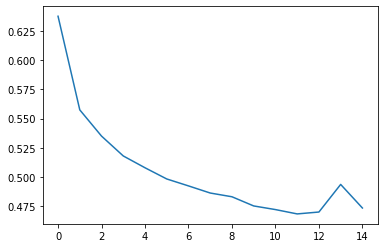

In [6]:
plt.plot(r.history['loss'],label='loss')
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = np.round(model.predict(X_test),0)

91/91 [==============================] - 0s 2ms/step


In [8]:
preds

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [9]:
print(confusion_matrix(y_test, preds))

[[1212  234]
 [ 603  843]]


In [10]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.67      0.84      0.74      1446
           1       0.78      0.58      0.67      1446

    accuracy                           0.71      2892
   macro avg       0.73      0.71      0.71      2892
weighted avg       0.73      0.71      0.71      2892



In [11]:
test_results = {}

test_results['model'] = model.evaluate(
    X_test, y_test, verbose=0)
accuracy = '{0:.2f}'.format(test_results['model'][1]*100)
print("Final Accuracy : ",accuracy,"%")

Final Accuracy :  71.06 %


In [12]:
inputs = []
# gender = input("Enter your gender : (Male,Female,Other)")
# if (gender=="Male" or gender=="male" or gender=="M"):
#     inputs.append(1)
# elif (gender=="Female" or gender=="female" or gender=="F"):
#     inputs.append(0)
# else:
#     inputs.append(2)
# age = float(input("Enter your age : "))
# inputs.append(age)

rest = [0,20,1,1,1,3,1,140,25.5,2]
inputs.extend(rest)
inputs = np.array(inputs)
inputs = inputs.reshape(-1,10)
inputs = sc.transform(inputs)
prediction = np.round(model.predict(inputs),0)
print(prediction[0])

1/1 [==============================] - 0s 21ms/step
[0.]


In [13]:
!jupyter nbconvert --to script StrokeClassifier.ipynb

[NbConvertApp] Converting notebook StrokeClassifier.ipynb to script
[NbConvertApp] Writing 3978 bytes to StrokeClassifier.py
